In [120]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [121]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [111]:
data.drop(['cbwd'], axis=1, inplace=True)


In [122]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [123]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


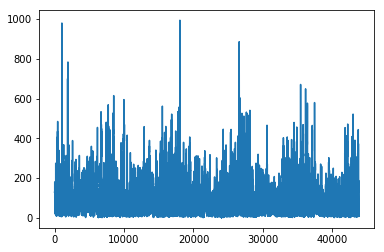

In [124]:
plt.plot(data['pm2.5'])

In [125]:
data['cbwd']=data['cbwd'].factorize()[0]

In [126]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [127]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [128]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [129]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

34867
4190
4191


In [130]:
trainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1],1))
valY=np.reshape(valY,(valY.shape[0],valY.shape[1],1))
testY=np.reshape(testY,(testY.shape[0],testY.shape[1],1))

In [131]:
print(trainX.shape)
print(trainY.shape)

(34867, 168, 8)
(34867, 24, 1)


### CNN-LSTM

In [141]:
first_input = Input(shape=(168,8))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 34867 samples, validate on 4190 samples
Epoch 1/20
34800/34867 [============================>.] - ETA: 0s - loss: 0.0057
Epoch 00001: val_loss improved from inf to 0.00447, saving model to saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5
34867/34867 [==============================] - 19s 553us/sample - loss: 0.0057 - val_loss: 0.0045
Epoch 2/20
34800/34867 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 00002: val_loss improved from 0.00447 to 0.00446, saving model to saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5
34867/34867 [==============================] - 18s 516us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 3/20
34800/34867 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss did not improve from 0.00446
34867/34867 [==============================] - 18s 516us/sample - loss: 0.0044 - val_loss: 0.0045
Epoch 4/20
34700/34867 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00004: val_loss improved from 0.00446 to 0.00437, 

KeyboardInterrupt: 

In [142]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 168, 8)]          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 168, 64)           2624      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 168, 64)           4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 84, 64)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0  

In [143]:
model.load_weights("saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5")

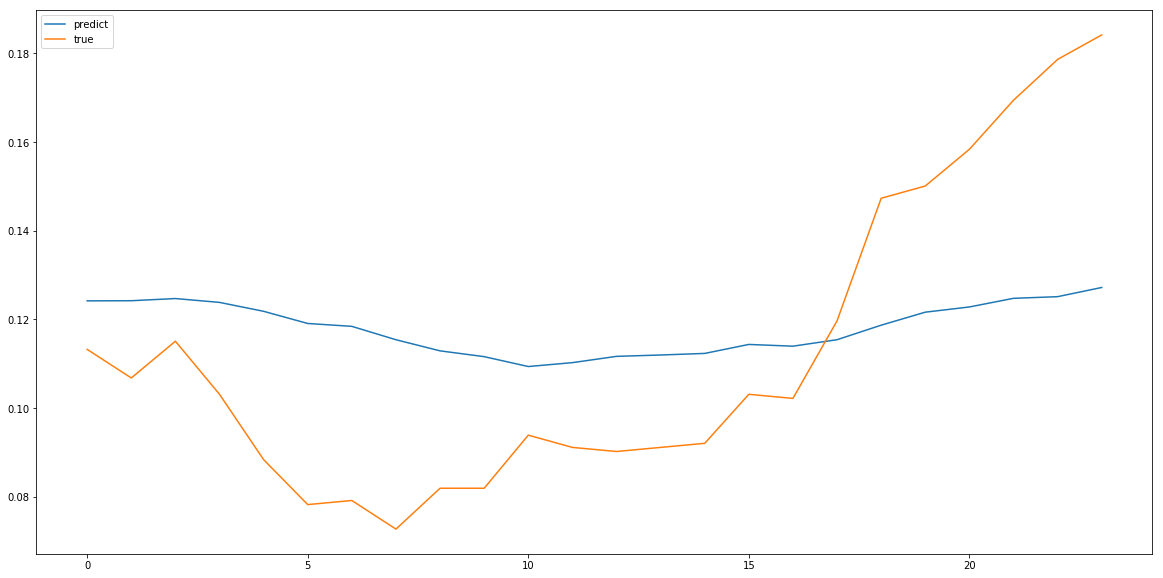

Test RMSE: 0.03036
Test MAE: 0.02699
Test MSE: 0.00092
Test RMSE: 32.96856
Test MAE: 29.30870


In [144]:
#1d(5,1)-LSTM(150) dense100-dense24
#saved_weights/pm2.5_1dcnn-lstm_multi2.hdf5
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*30]
testy=testY[24*30]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

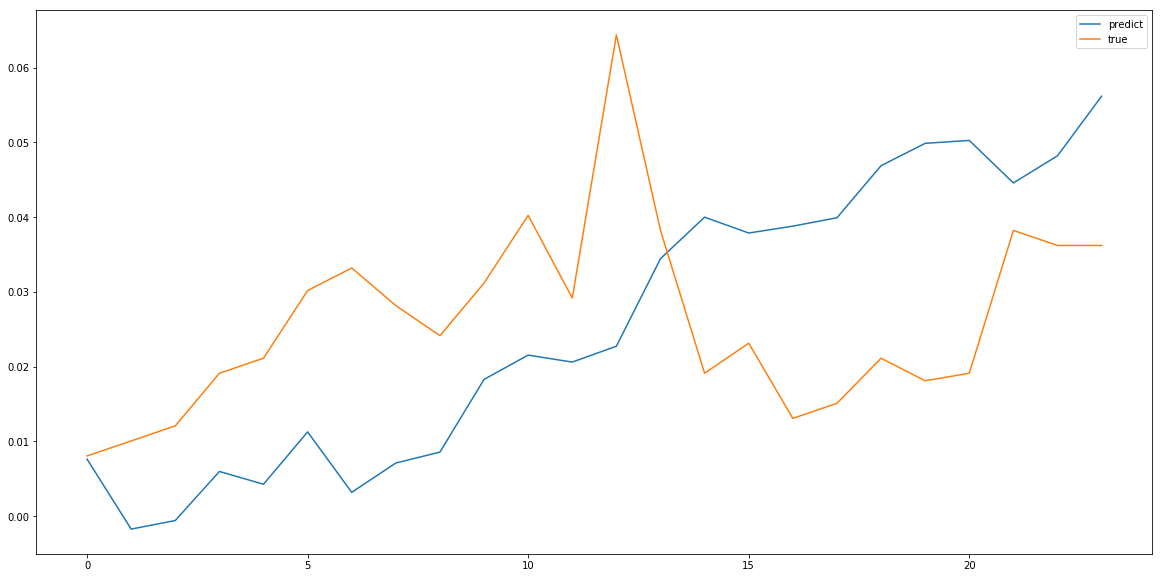

Test RMSE: 0.02061
Test MAE: 0.01830
Test MSE: 0.00042
Test RMSE: 22.38641
Test MAE: 19.87486


In [79]:
#1d(5,1)-LSTM(150) dense100-dense24
#saved_weights/pm2.5_1dcnn-lstm_multi2.hdf5
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*34]
testy=testY[24*34]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [145]:
import random
##133,106,130,143,111,172

    #print(i,random.randint(0,37))
j=np.random.choice(174,15,replace=False).tolist()

In [146]:
from math import *
from sklearn.metrics import *

non_aug_rm=[]
non_aug_ma=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    non_aug_rm.append(rmse)
    non_aug_ma.append(mae)


print(np.mean(non_aug_rm))
print(np.mean(non_aug_ma))

Test MAE: 0.02925
Test RMSE: 0.03224
Test MAE: 0.04771
Test RMSE: 0.05815
Test MAE: 0.01444
Test RMSE: 0.01747
Test MAE: 0.07141
Test RMSE: 0.08556
Test MAE: 0.01553
Test RMSE: 0.02137
Test MAE: 0.03769
Test RMSE: 0.03985
Test MAE: 0.03828
Test RMSE: 0.04357
Test MAE: 0.03392
Test RMSE: 0.05175
Test MAE: 0.01049
Test RMSE: 0.01193
Test MAE: 0.06836
Test RMSE: 0.08468
Test MAE: 0.13375
Test RMSE: 0.14465
Test MAE: 0.16610
Test RMSE: 0.17009
Test MAE: 0.01982
Test RMSE: 0.02209
Test MAE: 0.03443
Test RMSE: 0.03708
Test MAE: 0.02190
Test RMSE: 0.02662
0.05647355372742282
0.04953764


In [157]:
id_=24*40

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([ 12.,   6.,  11.,   6.,   6.,  11.,  10.,   9.,   9.,  14.,  21.,
        22.,  23.,  27.,  42.,  50.,  57.,  29.,  26.,  23.,  18.,  15.,
        12.,  17.,   8.,  10.,  12.,  19.,  21.,  30.,  33.,  28.,  24.,
        31.,  40.,  29.,  64.,  38.,  19.,  23.,  13.,  15.,  21.,  18.,
        19.,  38.,  36.,  36.,  53.,  55.,  43.,  38.,  26.,  17.,  17.,
        15.,  19.,  21.,  24.,  24.,  26.,  24.,  21.,  29.,  19.,  22.,
        22.,  16.,  28.,  35.,  17.,  25.,  27.,  26.,  26.,  28.,  42.,
        48.,  31.,  27.,  26.,  35.,  32.,  38.,  37.,  26.,  17.,  32.,
        26.,  34.,  32.,  23.,  35.,  71., 102., 121., 114.,  64.,  47.,
        26.,  17.,  12.,  17.,  34.,  48.,  22.,  30.,  27.,  24.,  28.,
        33.,  55.,  70.,  71.,  88.,  82.,  52.,  46.,  33.,  37.,  49.,
        71.,  68.,  48.,  44.,  38.,  28.,  52.,  63.,  56.,  61.,  74.,
        80.,  89.,  97., 172., 209.,  72.,  19.,  23.,  31.,  27.,  33.,
        38.,  36.,  39.,  44.,  37.,  36.,  28.,  3

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


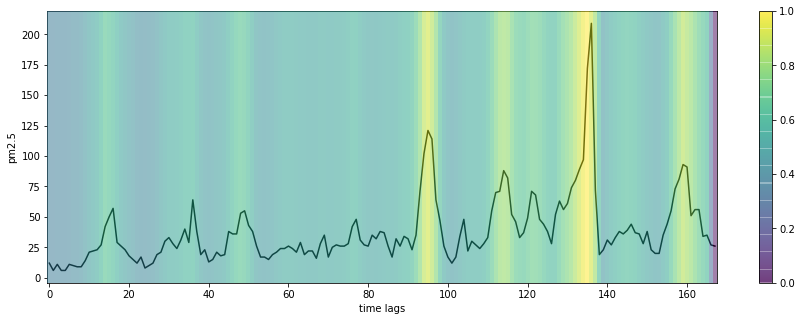

In [160]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20

id_=24*40
X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

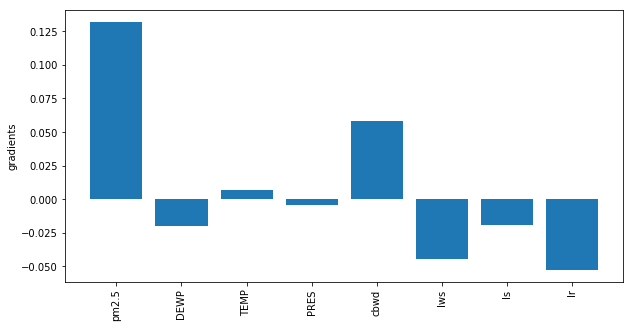

In [162]:

columns=data.columns[5:]
X_test=testX.copy()
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [33]:
from tensorflow.keras.models import Model

first_input = Input(shape=(48,11))


in1=Bidirectional(LSTM(150))(first_input)
in1=Dense(24,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/pm2.5_timebilst_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=200, verbose=1,callbacks=[cb])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 11)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               194400    
_________________________________________________________________
dense_4 (Dense)              (None, 24)                7224      
Total params: 201,624
Trainable params: 201,624
Non-trainable params: 0
_________________________________________________________________
Train on 34987 samples, validate on 4310 samples
Epoch 1/200
34944/34987 [============================>.] - ETA: 0s - loss: 0.0053
Epoch 00001: val_loss improved from inf to 0.00519, saving model to saved_weights/pm2.5_timebilst_multi.hdf5
34987/34987 [==============================] - 29s 821us/sample - loss: 0.0053 - val_loss: 0.0052
Epoch 2/200
34976/34987 [====================

KeyboardInterrupt: 

In [34]:
model.load_weights("saved_weights/pm2.5_timebilst_multi.hdf5")

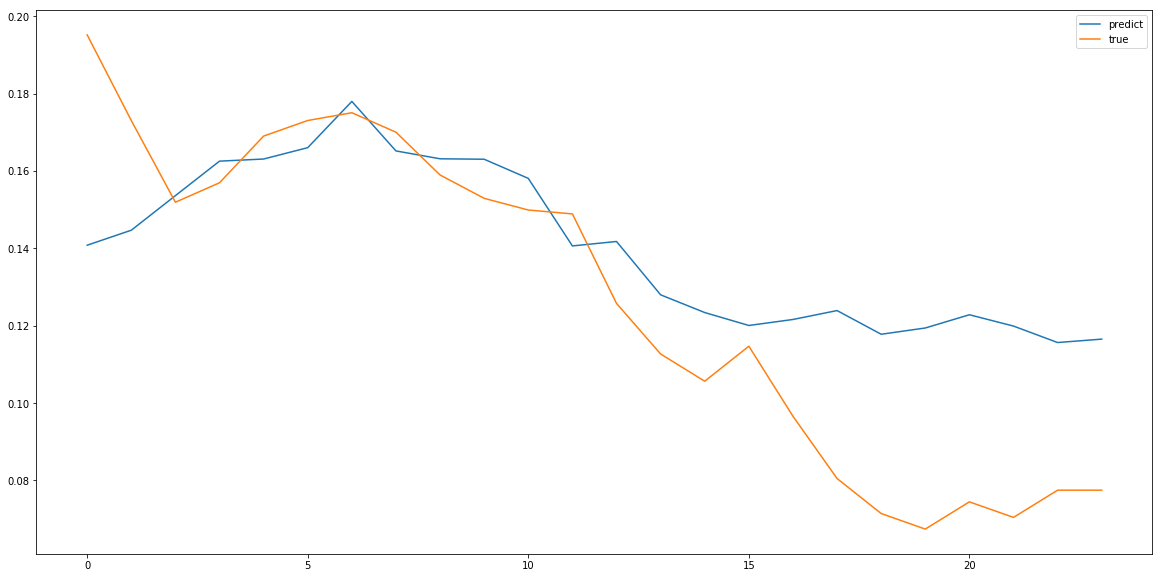

Test RMSE: 0.02896
Test MAE: 0.02241
Test MSE: 0.00084
Test RMSE: 31.45426
Test MAE: 24.33409


In [35]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[11]
testy=testY[11]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

### 1d-CNN

In [89]:
first_input = Input(shape=(48,11))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5_1dcnn_multi1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 48, 11)]          0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 48, 64)            2176      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 48, 64)            4160      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                36888     
Total params: 43,224
Trainable params: 43,224
Non-trainable params: 0
______________________________________________________

In [197]:
first_input = Input(shape=(168,8))

in1=Conv1D(filters=128, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=128, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=128, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5_1dcnn_multi_exp.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 168, 8)]          0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 168, 128)          2176      
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 168, 128)          32896     
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 168, 128)          16512     
_________________________________________________________________
extractor (MaxPooling1D)     (None, 84, 128)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10752)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               107

In [198]:
model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Train on 34867 samples, validate on 4190 samples
Epoch 1/200
34752/34867 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 00001: val_loss improved from inf to 0.00474, saving model to saved_weights/pm2.5_1dcnn_multi_exp.hdf5
34867/34867 [==============================] - 13s 385us/sample - loss: 0.0046 - val_loss: 0.0047
Epoch 2/200
34752/34867 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00002: val_loss improved from 0.00474 to 0.00462, saving model to saved_weights/pm2.5_1dcnn_multi_exp.hdf5
34867/34867 [==============================] - 13s 375us/sample - loss: 0.0041 - val_loss: 0.0046
Epoch 3/200
34752/34867 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 00003: val_loss improved from 0.00462 to 0.00452, saving model to saved_weights/pm2.5_1dcnn_multi_exp.hdf5
34867/34867 [==============================] - 13s 376us/sample - loss: 0.0039 - val_loss: 0.0045
Epoch 4/200
34720/34867 [============================>.] - ETA: 0s - loss: 0

KeyboardInterrupt: 

In [199]:
model.load_weights("saved_weights/pm2.5_1dcnn_multi_exp.hdf5")

In [186]:
j=[23, 34, 49, 83, 146, 4, 14, 77, 80, 159, 165, 43, 13, 6, 57]


In [200]:
aug_rm=[]
aug_ma=[]
for k in j:

    yhat = model.predict([testX])
    yhat=yhat[24*k]
    testy=testY[24*k]
    yhat=yhat.reshape(-1,1)
    testy=testy.reshape(-1,1)
    rmse = sqrt(mean_squared_error(testy, yhat))
    mae = mean_absolute_error(testy, yhat)
    print('Test MAE: %.5f' % mae)
    print('Test RMSE: %.5f' % rmse)
    aug_rm.append(rmse)
    aug_ma.append(mae)

    
print(np.mean(aug_rm))
print(np.mean(aug_ma))

Test MAE: 0.04089
Test RMSE: 0.04513
Test MAE: 0.01599
Test RMSE: 0.01991
Test MAE: 0.01726
Test RMSE: 0.02041
Test MAE: 0.01408
Test RMSE: 0.01803
Test MAE: 0.04391
Test RMSE: 0.04951
Test MAE: 0.01601
Test RMSE: 0.01880
Test MAE: 0.00955
Test RMSE: 0.01123
Test MAE: 0.02381
Test RMSE: 0.02927
Test MAE: 0.01390
Test RMSE: 0.01814
Test MAE: 0.03548
Test RMSE: 0.03819
Test MAE: 0.02355
Test RMSE: 0.03296
Test MAE: 0.06084
Test RMSE: 0.07932
Test MAE: 0.01829
Test RMSE: 0.02029
Test MAE: 0.01339
Test RMSE: 0.01715
Test MAE: 0.03598
Test RMSE: 0.03936
0.030514520775462992
0.02552841


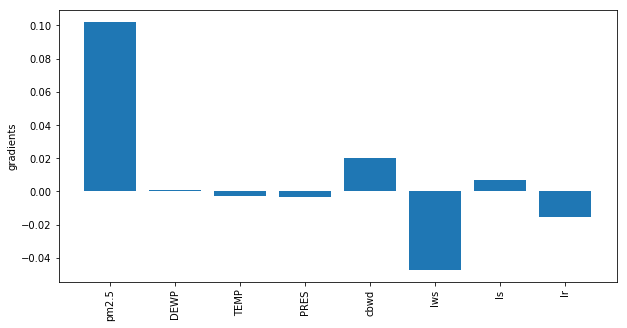

In [201]:

columns=data.columns[5:]
X_test=testX.copy()
id_=24*14
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

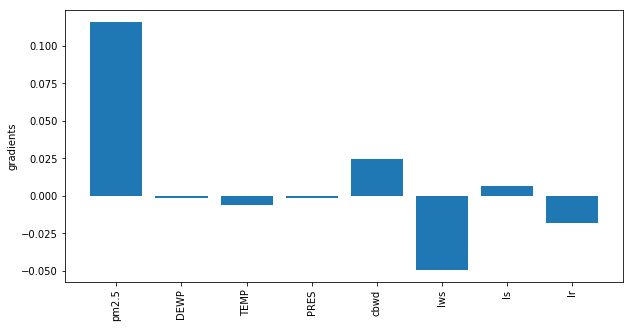

In [207]:

X_test=testX.copy()
id_=24*40
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [208]:
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([ 12.,   6.,  11.,   6.,   6.,  11.,  10.,   9.,   9.,  14.,  21.,
        22.,  23.,  27.,  42.,  50.,  57.,  29.,  26.,  23.,  18.,  15.,
        12.,  17.,   8.,  10.,  12.,  19.,  21.,  30.,  33.,  28.,  24.,
        31.,  40.,  29.,  64.,  38.,  19.,  23.,  13.,  15.,  21.,  18.,
        19.,  38.,  36.,  36.,  53.,  55.,  43.,  38.,  26.,  17.,  17.,
        15.,  19.,  21.,  24.,  24.,  26.,  24.,  21.,  29.,  19.,  22.,
        22.,  16.,  28.,  35.,  17.,  25.,  27.,  26.,  26.,  28.,  42.,
        48.,  31.,  27.,  26.,  35.,  32.,  38.,  37.,  26.,  17.,  32.,
        26.,  34.,  32.,  23.,  35.,  71., 102., 121., 114.,  64.,  47.,
        26.,  17.,  12.,  17.,  34.,  48.,  22.,  30.,  27.,  24.,  28.,
        33.,  55.,  70.,  71.,  88.,  82.,  52.,  46.,  33.,  37.,  49.,
        71.,  68.,  48.,  44.,  38.,  28.,  52.,  63.,  56.,  61.,  74.,
        80.,  89.,  97., 172., 209.,  72.,  19.,  23.,  31.,  27.,  33.,
        38.,  36.,  39.,  44.,  37.,  36.,  28.,  3

[5.e-03 3.e-03 3.e-05 2.e-03 5.e-03 9.e-03 1.e-02 3.e-02 4.e-02 4.e-02
 5.e-02 6.e-02 7.e-02 7.e-02 7.e-02 6.e-02 4.e-02 3.e-02 2.e-02 2.e-02
 1.e-02 8.e-03 7.e-03 8.e-03 8.e-03 9.e-03 1.e-02 6.e-03 9.e-04 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 3.e-04 6.e-04 4.e-04
 9.e-05 8.e-03 2.e-02 2.e-02 3.e-02 3.e-02 3.e-02 2.e-02 2.e-02 2.e-02
 2.e-02 2.e-02 3.e-02 3.e-02 4.e-02 4.e-02 4.e-02 4.e-02 5.e-02 6.e-02
 6.e-02 6.e-02 6.e-02 6.e-02 7.e-02 6.e-02 6.e-02 6.e-02 7.e-02 8.e-02
 9.e-02 9.e-02 1.e-01 9.e-02 9.e-02 9.e-02 1.e-01 1.e-01 1.e-01 9.e-02
 8.e-02 7.e-02 5.e-02 4.e-02 3.e-02 4.e-02 7.e-02 9.e-02 9.e-02 9.e-02
 9.e-02 8.e-02 9.e-02 9.e-02 9.e-02 9.e-02 8.e-02 7.e-02 7.e-02 6.e-02
 3.e-02 2.e-02 1.e-02 5.e-03 3.e-03 2.e-03 2.e-03 3.e-03 3.e-03 3.e-03
 2.e-03 2.e-03 2.e-03 2.e-03 2.e-03 2.e-02 7.e-02 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-0

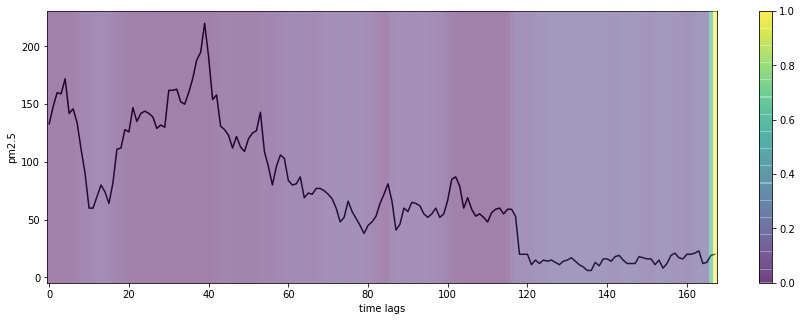

In [203]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


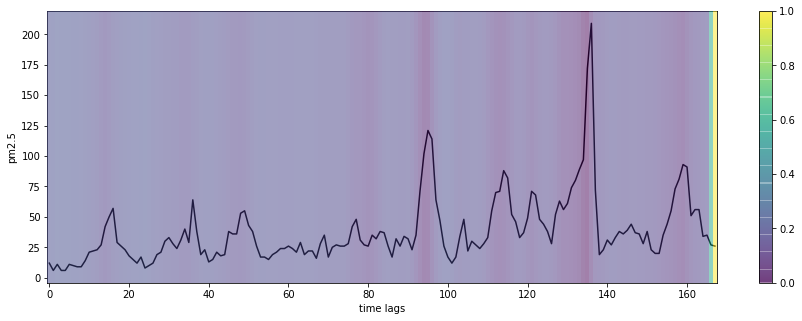

In [209]:
from scipy.ndimage import zoom
import random
import pylab

#id_=24*20


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*100), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

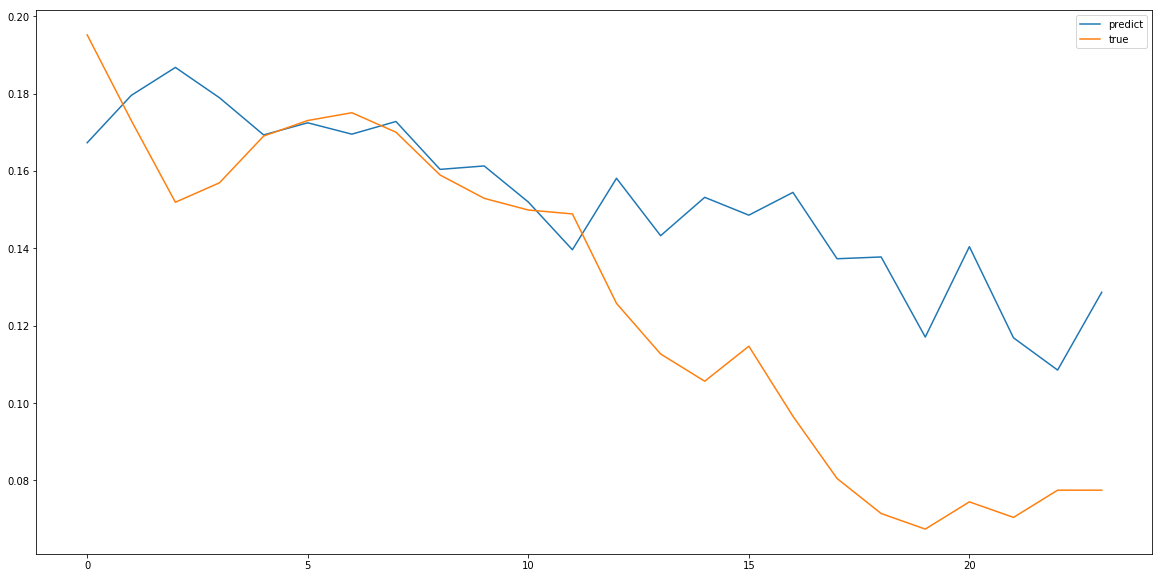

Test RMSE: 0.03631
Test MAE: 0.02880
Test MSE: 0.00132
Test RMSE: 39.43292
Test MAE: 31.27782


In [92]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[11]
testy=testY[11]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

### timedistributed 1dcnn

In [40]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [ ]:
trainY = np.reshape(trainY, (trainY.shape[0],1, trainY.shape[1], trainY.shape[2]))
valY = np.reshape(valY, (valY.shape[0],1, valY.shape[1],valY.shape[2]))
testY = np.reshape(testY, (testY.shape[0],1,testY.shape[1], testY.shape[2] ))

In [46]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,48,11))

in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
in1=TimeDistributed(RepeatVector(24))(in1)
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

model.summary()
checkpoint_path = "saved_weights/pm2.5_conv1d_timedist_5_1_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, None, 48, 11)]    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 44, 64)      3584      
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 44, 64)      4160      
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 22, 64)      0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 1408)        0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 24, 1408)    0         
_________________________________________________________________
dense_9 (Dense)              (None, None, 24, 1)       1409

ValueError: A target array with shape (34987, 24, 1) was passed for an output of shape (None, None, 24, 1) while using as loss `mean_squared_error`. This loss expects targets to have the same shape as the output.

In [676]:
model.load_weights("saved_weights/pm2.5_conv1d_5_1.hdf5")

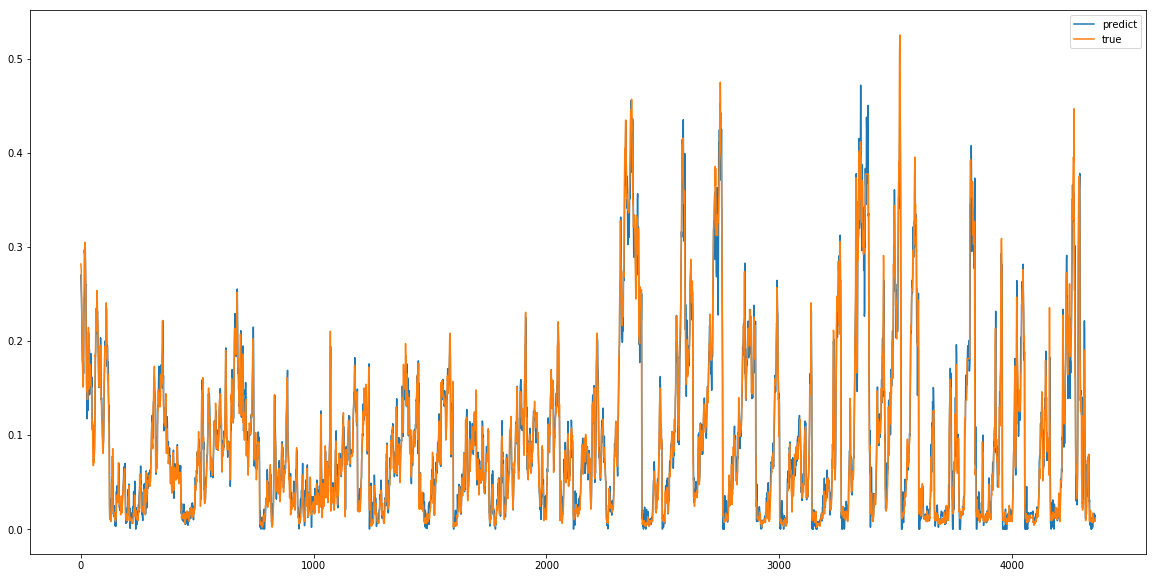

Test RMSE: 0.02106
Test MAE: 0.01326
Test MSE: 0.00044
Test RMSE: 22.86943
Test MAE: 14.40256


In [680]:
#1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### LSTM-CNN

In [220]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,11))

in1=LSTM(units =100 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
#in1=Dropout(0.2)(in1)
out1=Dense(24, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_lstmcnn_mulstep1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [95]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 168, 11)]         0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 168, 100)          44800     
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 164, 64)           32064     
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 164, 64)           4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 82, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5248)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 24)                125

In [96]:
history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 34867 samples, validate on 4190 samples
Epoch 1/100
34800/34867 [============================>.] - ETA: 0s - loss: 0.0065
Epoch 00001: val_loss improved from inf to 0.00594, saving model to saved_weights/pm2.5_lstmcnn_mulstep1.hdf5
34867/34867 [==============================] - 38s 1ms/sample - loss: 0.0065 - val_loss: 0.0059
Epoch 2/100
34800/34867 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 00002: val_loss did not improve from 0.00594
34867/34867 [==============================] - 36s 1ms/sample - loss: 0.0051 - val_loss: 0.0062
Epoch 3/100
34800/34867 [============================>.] - ETA: 0s - loss: 0.0043
Epoch 00003: val_loss did not improve from 0.00594
34867/34867 [==============================] - 36s 1ms/sample - loss: 0.0043 - val_loss: 0.0068
Epoch 4/100
34800/34867 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 00004: val_loss did not improve from 0.00594
34867/34867 [==============================] - 36s 1ms/sample - loss: 0.

KeyboardInterrupt: 

In [221]:
model.load_weights("saved_weights/pm2.5_lstmcnn_mulstep1.hdf5")

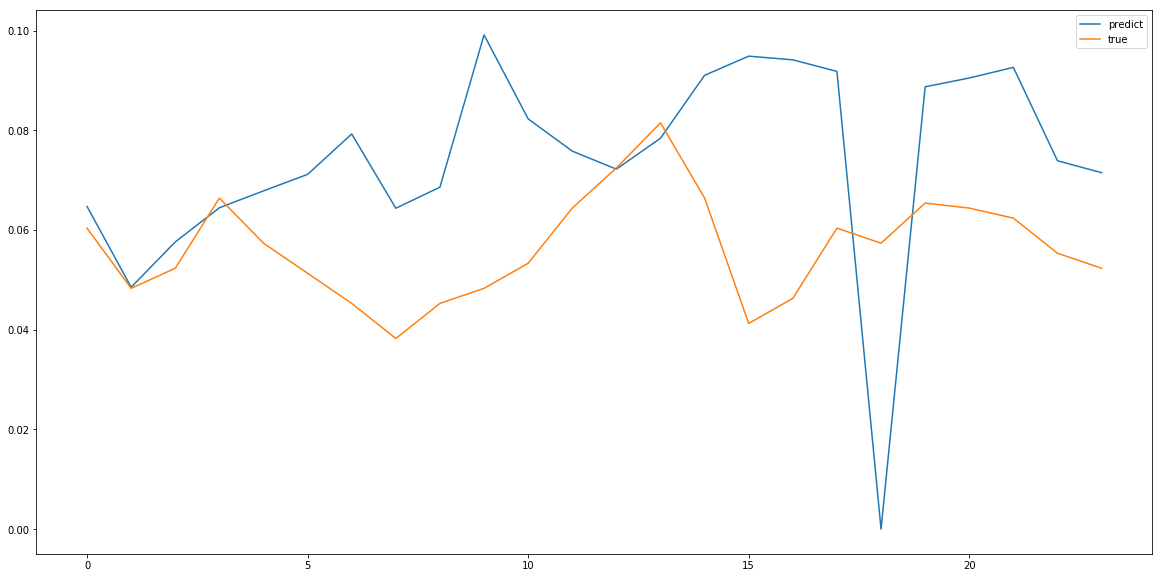

Test RMSE: 0.02843
Test MAE: 0.02301
Test MSE: 0.00081
Test RMSE: 30.87295
Test MAE: 24.99366


In [100]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24*10]
testy=testY[24*10]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [217]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [222]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 5
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[7].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output)
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

ValueError: Error when checking input: expected input_29 to have shape (168, 11) but got array with shape (168, 8)

In [101]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

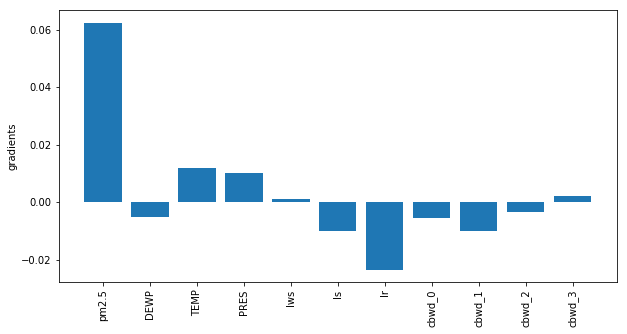

In [103]:

columns=data.columns[5:]
X_test=testX.copy()
id_=24*10
grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [104]:
id_=24*10

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

#X_test[id_][:,0].shape

array([-29., -30., -32., -33., -33., -33., -33., -33., -33., -27., -21.,
       -23., -19., -16., -18.,  -1.,  -2.,  -7., -26., -19., -18., -20.,
       -21., -21., -29., -26., -26., -29., -29., -27., -28., -30., -18.,
       -17., -18., -12.,  -2.,  23.,   9.,  15.,  23.,   8.,  10.,  -6.,
       -15., -17., -14., -19., -16., -20., -19., -17., -16.,  -8.,  -1.,
         3.,  -1.,   6.,   2.,  -1.,  -7., -24., -19.,  -7.,  26.,   4.,
        -8.,  -2.,   4.,   6.,   0.,   8.,  14.,  15.,  17.,  15.,  17.,
        15.,  20.,  22.,   9.,  16.,  14.,  19.,  28.,  40.,  48.,  62.,
        78.,  82.,  83.,  53.,  58.,  53.,  92., 102., 105., 122., 135.,
       134., 148., 115., 120., 106.,  81.,  58.,  26.,  26.,  36.,  47.,
        41.,  30.,  50.,  81.,  82., 100.,  98., 121., 107., 115., 117.,
       115., 112., 101., 104., 102., 137., 137., 138., 126., 124., 135.,
       148., 165., 173., 200., 169., 128., 133., 103., 100.,  94.,  82.,
        93.,  83.,  79.,  91.,  97.,  99., 116.,  7

In [446]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_28107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_214 (Conv1D)          (None, 24, 64)            2624      
_________________________________________________________________
conv1d_216 (Conv1D)          (None, 24, 64)            4160      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
flatten_73 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 769       
Total params: 7,553
Trainable params: 7,553
Non-trainable params: 0
_____________________________________________________

In [382]:
model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34592/35035 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00001: val_loss improved from inf to 0.00069, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 97us/sample - loss: 0.0014 - val_loss: 6.8992e-04
Epoch 2/200
34944/35035 [============================>.] - ETA: 0s - loss: 6.8577e-04
Epoch 00002: val_loss improved from 0.00069 to 0.00065, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 97us/sample - loss: 6.8521e-04 - val_loss: 6.4689e-04
Epoch 3/200
34688/35035 [============================>.] - ETA: 0s - loss: 6.2399e-04
Epoch 00003: val_loss did not improve from 0.00065
35035/35035 [==============================] - 3s 77us/sample - loss: 6.2212e-04 - val_loss: 6.8445e-04
Epoch 4/200
34528/35035 [============================>.] - ETA: 0s - loss: 5.9540e-04
Epoch 00004: val_loss improved from 0.00065 to 0.00060, saving

34720/35035 [============================>.] - ETA: 0s - loss: 5.1415e-04
Epoch 00033: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 76us/sample - loss: 5.1461e-04 - val_loss: 5.5305e-04
Epoch 34/200
34912/35035 [============================>.] - ETA: 0s - loss: 5.0276e-04
Epoch 00034: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 73us/sample - loss: 5.0214e-04 - val_loss: 5.4520e-04
Epoch 35/200
34784/35035 [============================>.] - ETA: 0s - loss: 5.0503e-04
Epoch 00035: val_loss did not improve from 0.00054
35035/35035 [==============================] - 3s 85us/sample - loss: 5.0570e-04 - val_loss: 5.4562e-04
Epoch 36/200
35008/35035 [============================>.] - ETA: 0s - loss: 5.1125e-04
Epoch 00036: val_loss improved from 0.00054 to 0.00054, saving model to saved_weights/pm2.5.hdf5
35035/35035 [==============================] - 3s 83us/sample - loss: 5.1115e-04 - val_loss: 5.4257e-04

Epoch 66/200
34880/35035 [============================>.] - ETA: 0s - loss: 4.8814e-04
Epoch 00066: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 76us/sample - loss: 4.8743e-04 - val_loss: 5.4918e-04
Epoch 67/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.8649e-04
Epoch 00067: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 83us/sample - loss: 4.8689e-04 - val_loss: 5.5510e-04
Epoch 68/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.8725e-04
Epoch 00068: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.8574e-04 - val_loss: 5.3360e-04
Epoch 69/200
34496/35035 [============================>.] - ETA: 0s - loss: 4.8727e-04
Epoch 00069: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 84us/sample - loss: 4.8503e-04 - val_loss: 5.4039e-04
Epoch 70/200
34912/35035 [======

Epoch 100/200
34208/35035 [============================>.] - ETA: 0s - loss: 4.8366e-04
Epoch 00100: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.8096e-04 - val_loss: 5.4280e-04
Epoch 101/200
34432/35035 [============================>.] - ETA: 0s - loss: 4.7308e-04
Epoch 00101: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.7382e-04 - val_loss: 5.8780e-04
Epoch 102/200
34432/35035 [============================>.] - ETA: 0s - loss: 4.6668e-04
Epoch 00102: val_loss did not improve from 0.00053
35035/35035 [==============================] - 2s 67us/sample - loss: 4.6940e-04 - val_loss: 6.2278e-04
Epoch 103/200
34368/35035 [============================>.] - ETA: 0s - loss: 4.7114e-04
Epoch 00103: val_loss did not improve from 0.00053
35035/35035 [==============================] - 3s 75us/sample - loss: 4.7084e-04 - val_loss: 5.6942e-04
Epoch 104/200
34432/35035 [=

Epoch 134/200
34752/35035 [============================>.] - ETA: 0s - loss: 4.5919e-04
Epoch 00134: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 64us/sample - loss: 4.5787e-04 - val_loss: 5.5080e-04
Epoch 135/200
34880/35035 [============================>.] - ETA: 0s - loss: 4.6073e-04
Epoch 00135: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 78us/sample - loss: 4.6268e-04 - val_loss: 5.6552e-04
Epoch 136/200
34976/35035 [============================>.] - ETA: 0s - loss: 4.6257e-04
Epoch 00136: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 89us/sample - loss: 4.6231e-04 - val_loss: 5.5510e-04
Epoch 137/200
34688/35035 [============================>.] - ETA: 0s - loss: 4.5471e-04
Epoch 00137: val_loss did not improve from 0.00052
35035/35035 [==============================] - 3s 87us/sample - loss: 4.5461e-04 - val_loss: 5.9885e-04
Epoch 138/200
34912/35035 [=

Epoch 168/200
34944/35035 [============================>.] - ETA: 0s - loss: 4.5057e-04
Epoch 00168: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 69us/sample - loss: 4.5072e-04 - val_loss: 5.6552e-04
Epoch 169/200
34368/35035 [============================>.] - ETA: 0s - loss: 4.5141e-04
Epoch 00169: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 70us/sample - loss: 4.5320e-04 - val_loss: 5.8176e-04
Epoch 170/200
34784/35035 [============================>.] - ETA: 0s - loss: 4.4748e-04
Epoch 00170: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 71us/sample - loss: 4.4648e-04 - val_loss: 5.8705e-04
Epoch 171/200
34624/35035 [============================>.] - ETA: 0s - loss: 4.4726e-04
Epoch 00171: val_loss did not improve from 0.00052
35035/35035 [==============================] - 2s 69us/sample - loss: 4.4836e-04 - val_loss: 5.8594e-04
Epoch 172/200
35008/35035 [=

In [383]:
model.load_weights("saved_weights/pm2.5.hdf5")

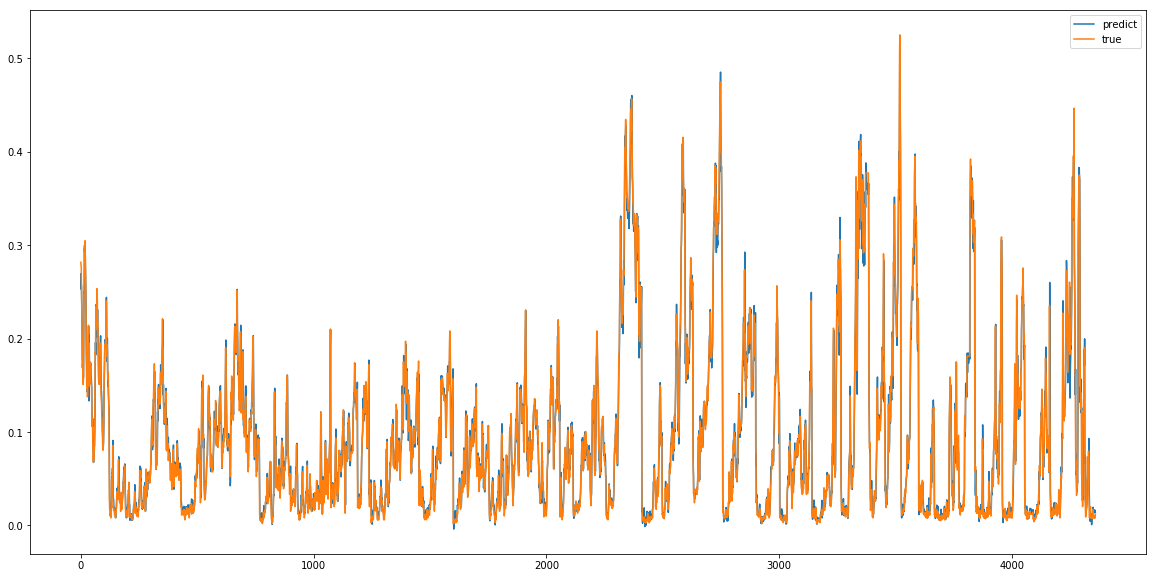

In [384]:
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [385]:
##1dcnn

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01773


In [730]:

from tensorflow.keras.models import *

first_input = Input(shape=(None,24,11))

in1=TimeDistributed(Conv1D(filters=64, kernel_size=7, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_conv1d_timedist_71.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

In [731]:
model.summary()

Model: "model_28149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       [(None, None, 24, 11)]    0         
_________________________________________________________________
time_distributed_375 (TimeDi (None, None, 18, 64)      4992      
_________________________________________________________________
time_distributed_376 (TimeDi (None, None, 18, 64)      4160      
_________________________________________________________________
time_distributed_377 (TimeDi (None, None, 9, 64)       0         
_________________________________________________________________
time_distributed_378 (TimeDi (None, None, 576)         0         
_________________________________________________________________
dense_130 (Dense)            (None, None, 1)           577       
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_____________________________________________________

In [552]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))
test1X = np.reshape(test1X, (test1X.shape[0],1,test1X.shape[1], test1X.shape[2] ))

In [732]:
trainX.shape

(35035, 1, 24, 11)

In [733]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34600/35035 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00001: val_loss improved from inf to 0.00165, saving model to saved_weights/pm2.5_conv1d_timedist_71.hdf5
35035/35035 [==============================] - 2s 56us/sample - loss: 0.0027 - val_loss: 0.0017
Epoch 2/200
34500/35035 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00165 to 0.00136, saving model to saved_weights/pm2.5_conv1d_timedist_71.hdf5
35035/35035 [==============================] - 1s 38us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00003: val_loss improved from 0.00136 to 0.00105, saving model to saved_weights/pm2.5_conv1d_timedist_71.hdf5
35035/35035 [==============================] - 1s 37us/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 4/200
34600/35035 [============================>.] - ETA: 0s - loss

Epoch 32/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.8950e-04
Epoch 00032: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.8966e-04 - val_loss: 7.1656e-04
Epoch 33/200
34500/35035 [============================>.] - ETA: 0s - loss: 5.0246e-04
Epoch 00033: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 5.0214e-04 - val_loss: 6.8970e-04
Epoch 34/200
33600/35035 [===========================>..] - ETA: 0s - loss: 4.9113e-04
Epoch 00034: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 36us/sample - loss: 4.9184e-04 - val_loss: 6.9597e-04
Epoch 35/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.7557e-04
Epoch 00035: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.7460e-04 - val_loss: 6.9830e-04
Epoch 36/200
34700/35035 [======

Epoch 66/200
34800/35035 [============================>.] - ETA: 0s - loss: 4.0623e-04
Epoch 00066: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.0581e-04 - val_loss: 7.4564e-04
Epoch 67/200
34800/35035 [============================>.] - ETA: 0s - loss: 4.0793e-04
Epoch 00067: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.0780e-04 - val_loss: 7.1433e-04
Epoch 68/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.2212e-04
Epoch 00068: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.2333e-04 - val_loss: 7.6218e-04
Epoch 69/200
34600/35035 [============================>.] - ETA: 0s - loss: 4.0518e-04
Epoch 00069: val_loss did not improve from 0.00066
35035/35035 [==============================] - 1s 37us/sample - loss: 4.0754e-04 - val_loss: 7.7975e-04
Epoch 70/200
34500/35035 [======

KeyboardInterrupt: 

In [734]:
model.load_weights("saved_weights/pm2.5_conv1d_timedist_71.hdf5")

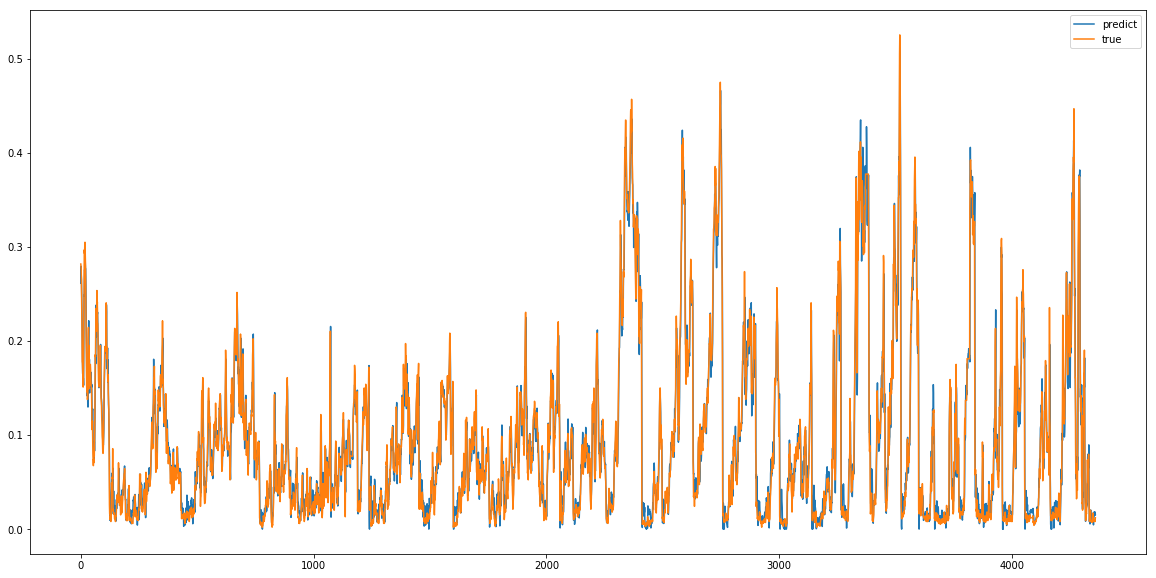

In [735]:
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [737]:
### timedistribute 1dcnn

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.02032
Test RMSE: 22.06434


In [745]:
first_input = Input(shape=(None,24,11))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')




In [746]:
model.summary()

Model: "model_28151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_125 (InputLayer)       [(None, None, 24, 11)]    0         
_________________________________________________________________
time_distributed_384 (TimeDi (None, None, 24, 150)     97200     
_________________________________________________________________
time_distributed_385 (TimeDi (None, None, 22, 64)      28864     
_________________________________________________________________
time_distributed_386 (TimeDi (None, None, 22, 64)      4160      
_________________________________________________________________
time_distributed_387 (TimeDi (None, None, 11, 64)      0         
_________________________________________________________________
time_distributed_388 (TimeDi (None, None, 704)         0         
_________________________________________________________________
dense_132 (Dense)            (None, None, 1)           

In [747]:
checkpoint_path = "saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [748]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00001: val_loss improved from inf to 0.00129, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 12s 334us/sample - loss: 0.0025 - val_loss: 0.0013
Epoch 2/200
34900/35035 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00002: val_loss improved from 0.00129 to 0.00098, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 0.0011 - val_loss: 9.8348e-04
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 7.8606e-04
Epoch 00003: val_loss improved from 0.00098 to 0.00070, saving model to saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5
35035/35035 [==============================] - 8s 222us/sample - loss: 7.8500e-04 - val_loss: 7.0265e-04
Epoch 4/200
34900

Epoch 33/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0438e-04
Epoch 00033: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0358e-04 - val_loss: 5.9479e-04
Epoch 34/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.0077e-04
Epoch 00034: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 5.0037e-04 - val_loss: 5.9754e-04
Epoch 35/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.9350e-04
Epoch 00035: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 4.9318e-04 - val_loss: 6.2706e-04
Epoch 36/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.8462e-04
Epoch 00036: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.8414e-04 - val_loss: 6.0748e-04
Epoch 37/200
34900/35035 [==

Epoch 67/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.0061e-04
Epoch 00067: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 4.0032e-04 - val_loss: 6.7587e-04
Epoch 68/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9725e-04
Epoch 00068: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.9677e-04 - val_loss: 6.3896e-04
Epoch 69/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.9500e-04
Epoch 00069: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.9482e-04 - val_loss: 6.3722e-04
Epoch 70/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.8710e-04
Epoch 00070: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.8710e-04 - val_loss: 6.3130e-04
Epoch 71/200
34900/35035 [==

Epoch 101/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0023e-04
Epoch 00101: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 3.0032e-04 - val_loss: 6.8575e-04
Epoch 102/200
34900/35035 [============================>.] - ETA: 0s - loss: 3.0234e-04
Epoch 00102: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 3.0215e-04 - val_loss: 6.8568e-04
Epoch 103/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9850e-04
Epoch 00103: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.9849e-04 - val_loss: 6.9050e-04
Epoch 104/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.9583e-04
Epoch 00104: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.9591e-04 - val_loss: 7.4253e-04
Epoch 105/200
34900/3503

Epoch 135/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.3214e-04
Epoch 00135: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.3212e-04 - val_loss: 7.7176e-04
Epoch 136/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2495e-04
Epoch 00136: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 2.2509e-04 - val_loss: 7.7548e-04
Epoch 137/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2928e-04
Epoch 00137: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2957e-04 - val_loss: 7.7703e-04
Epoch 138/200
34900/35035 [============================>.] - ETA: 0s - loss: 2.2232e-04
Epoch 00138: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 2.2320e-04 - val_loss: 7.7343e-04
Epoch 139/200
34900/3503

Epoch 169/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7681e-04
Epoch 00169: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7693e-04 - val_loss: 7.8670e-04
Epoch 170/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6890e-04
Epoch 00170: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 222us/sample - loss: 1.6904e-04 - val_loss: 8.4811e-04
Epoch 171/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.6668e-04
Epoch 00171: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.6652e-04 - val_loss: 8.0984e-04
Epoch 172/200
34900/35035 [============================>.] - ETA: 0s - loss: 1.7098e-04
Epoch 00172: val_loss did not improve from 0.00057
35035/35035 [==============================] - 8s 221us/sample - loss: 1.7098e-04 - val_loss: 8.2017e-04
Epoch 173/200
34900/3503

In [742]:
model.load_weights("saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5")

In [ ]:
## lstm(150)-cnn(3,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae )

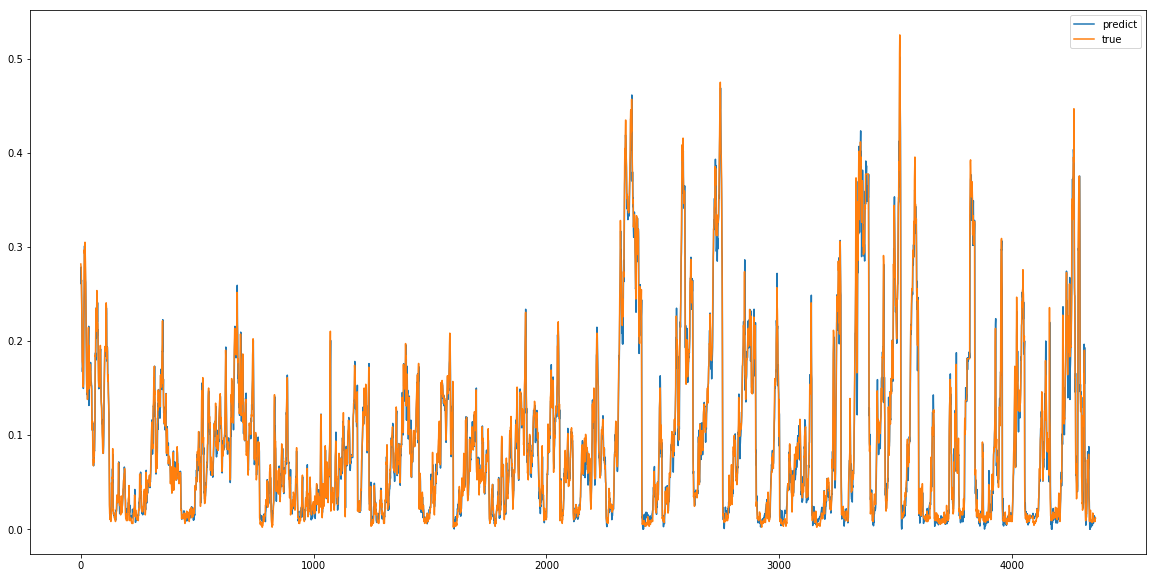

Test RMSE: 0.01806
Test MAE: 0.01101
Test MSE: 0.00033
Test RMSE: 19.61045
Test MAE: 11.95379


In [744]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae )

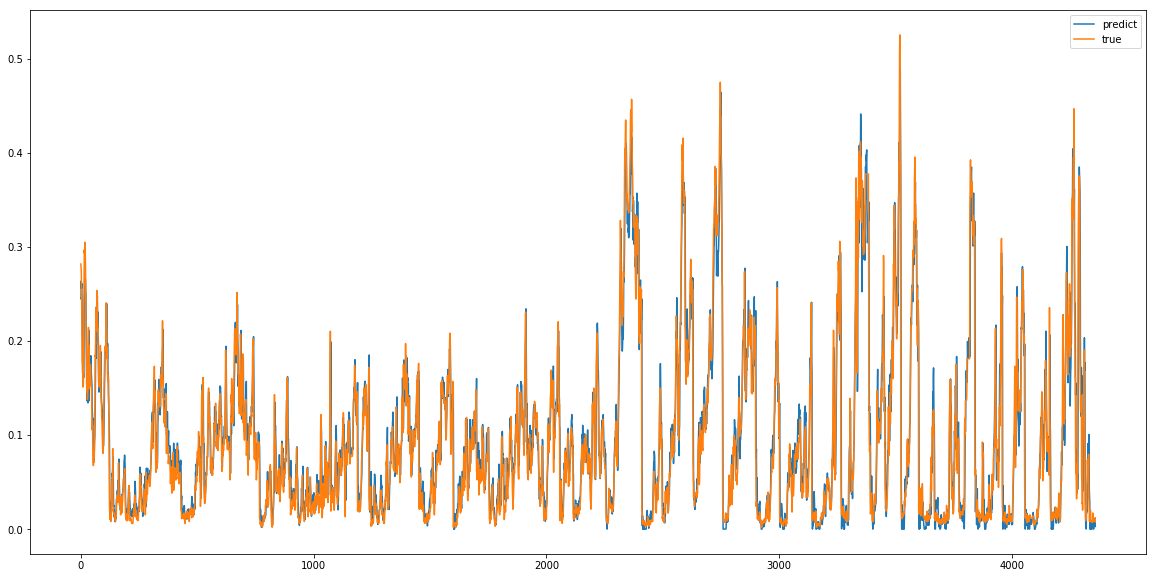

Test RMSE: 0.02786
Test MAE: 0.01743
Test MSE: 0.00078
Test RMSE: 30.25511


In [729]:
## lstm(150)-cnn(2,2.1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

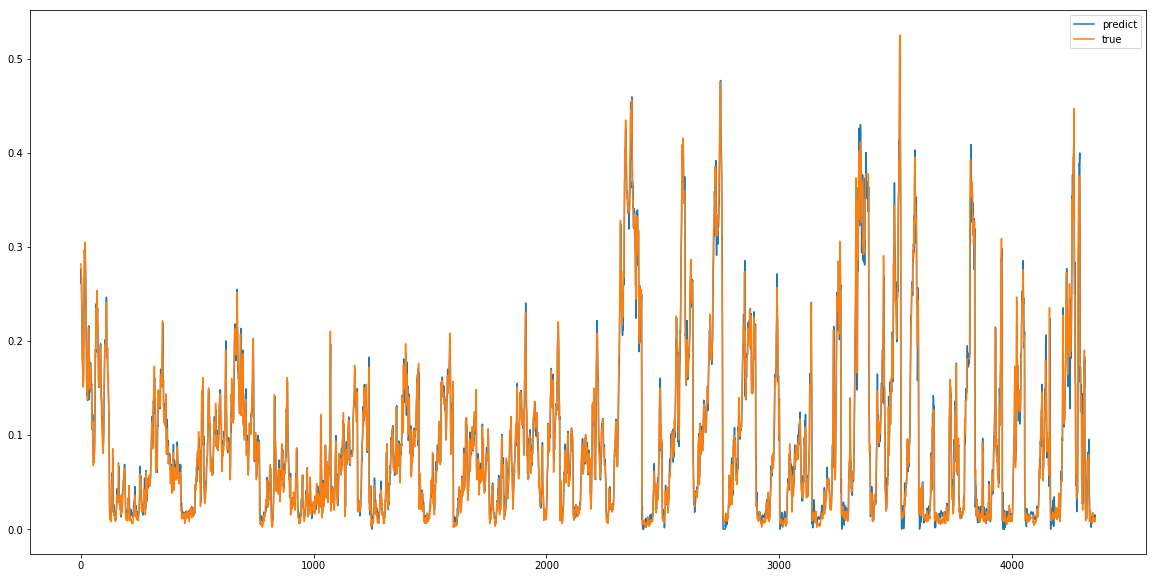

Test RMSE: 0.01818
Test MAE: 0.01115
Test MSE: 0.00033
Test RMSE: 19.740


In [638]:
## lstm(150)-cnn(3,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

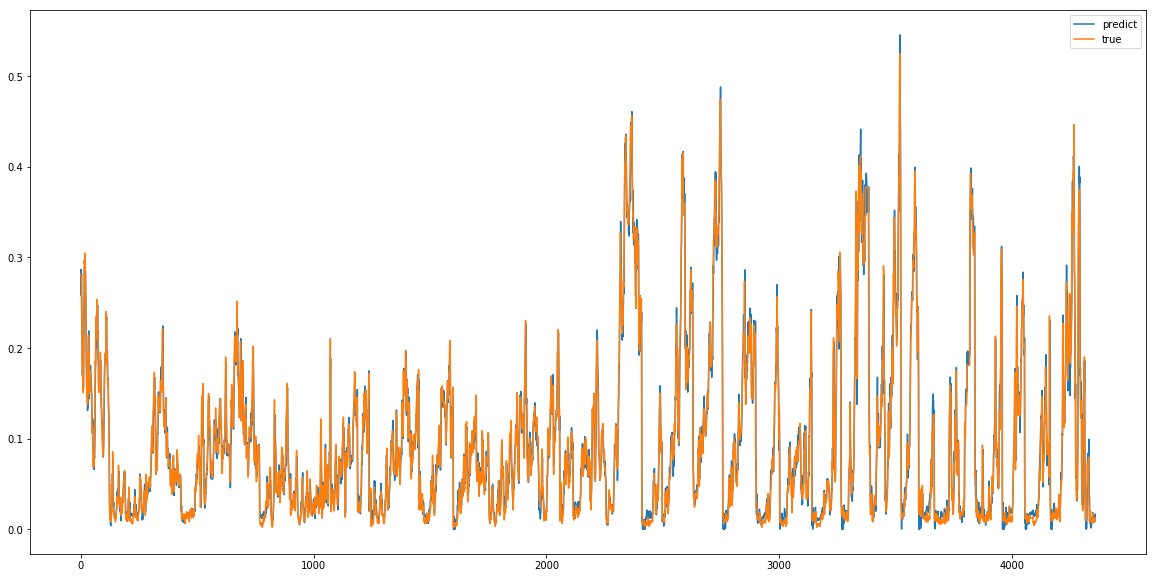

Test RMSE: 0.01849
Test MAE: 0.01152
Test MSE: 0.00034
Test RMSE: 20.077


In [589]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

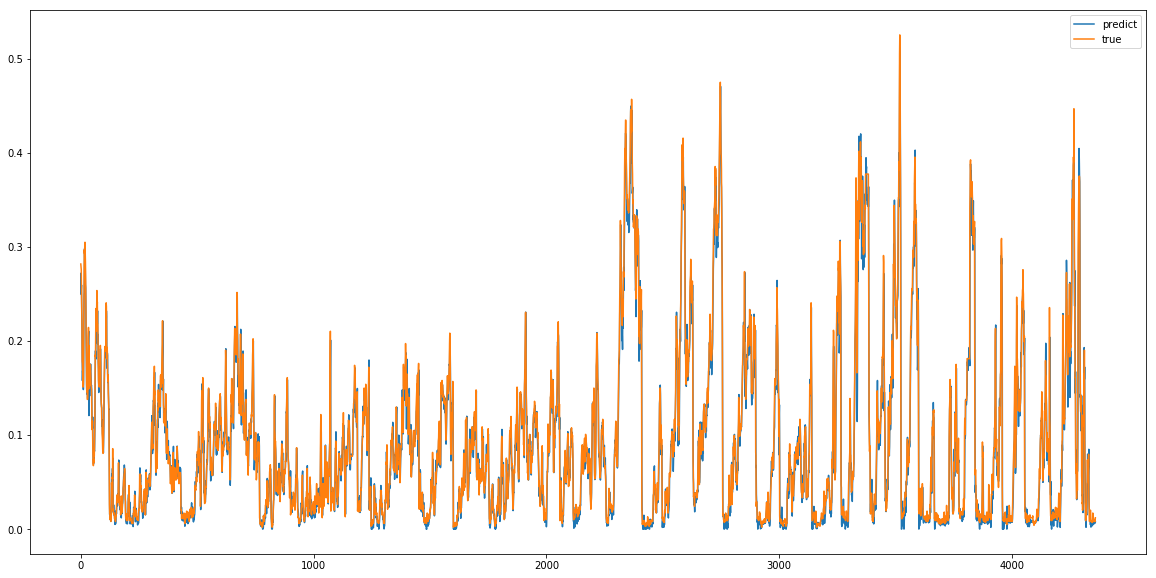

Test RMSE: 0.01820
Test MAE: 0.01122
Test MSE: 0.00033
Test RMSE: 19.764


In [577]:
## lstm(150)-cnn(5,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

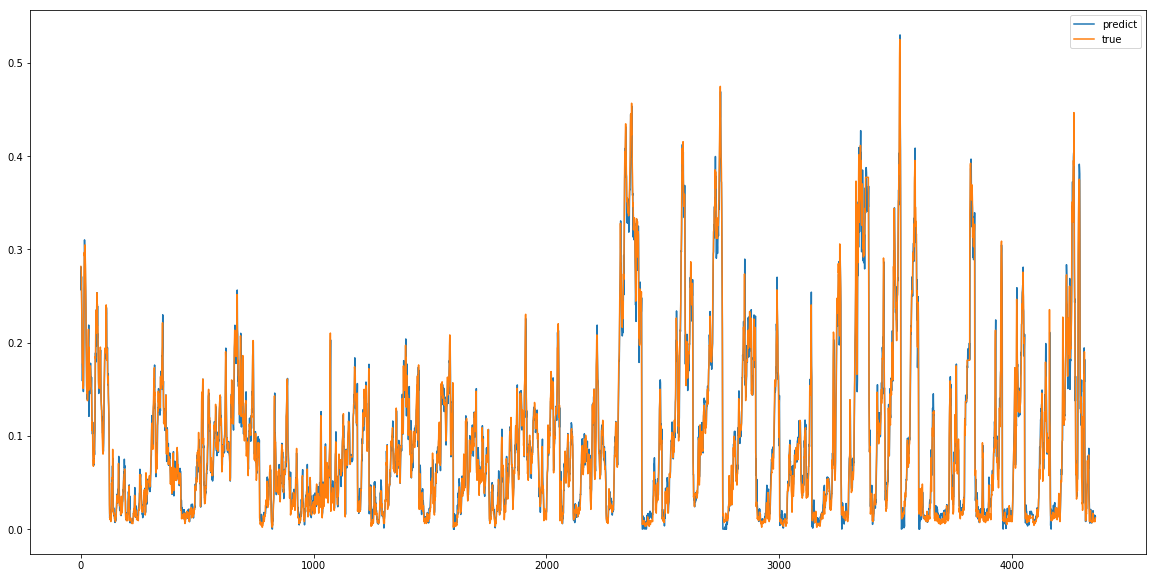

Test RMSE: 0.01831
Test MAE: 0.01130
Test MSE: 0.00034
Test RMSE: 19.885


In [559]:
## lstm(50)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

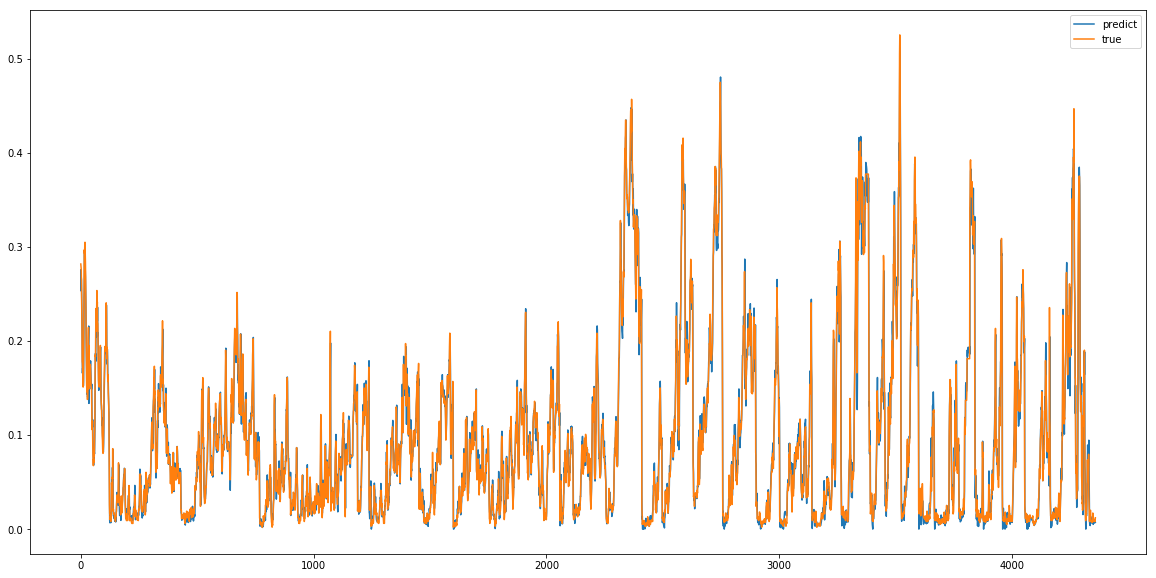

Test RMSE: 0.01770
Test MAE: 0.01071
Test MSE: 0.00031
Test RMSE: 19.21818
Test MAE: 11.63510


In [572]:
## lstm(150)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


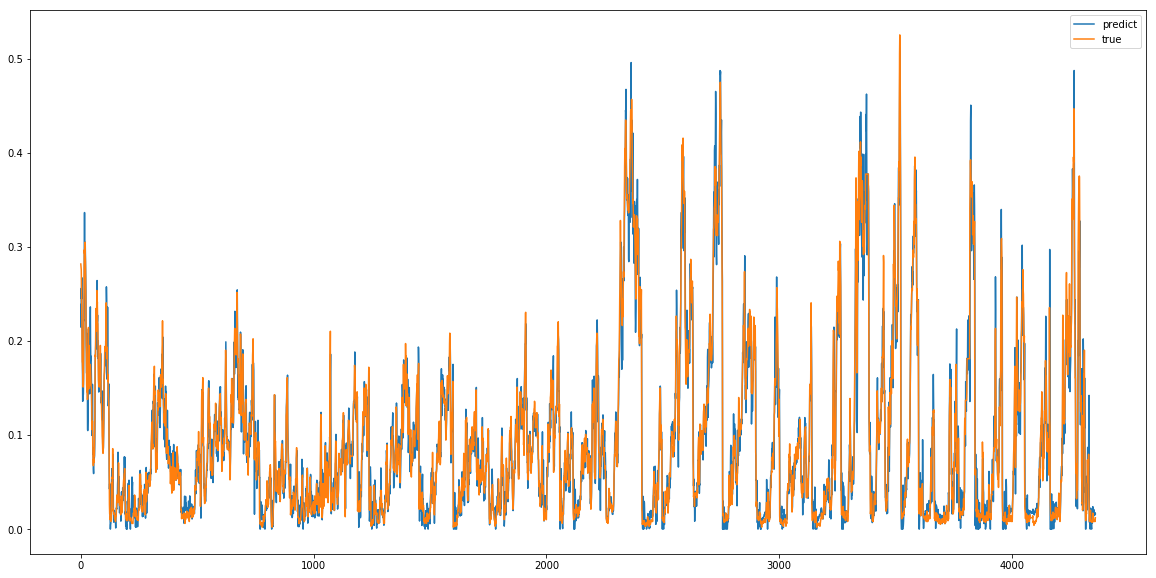

Test RMSE: 0.02343
Test MAE: 0.01534
Test MSE: 0.00055
Test RMSE: 25.447


In [582]:
## lstm(150)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

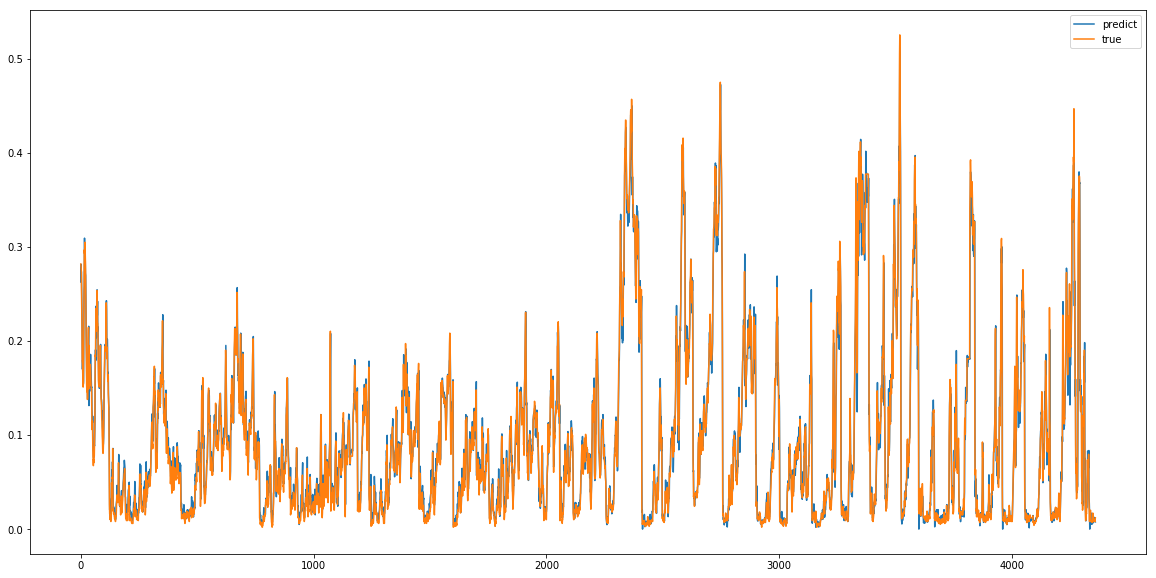

Test RMSE: 0.01783
Test MAE: 0.01091
Test MSE: 0.00032
Test RMSE: 19.36649
Test MAE: 11.85078


In [644]:
## lstm(100)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [535]:
yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)

In [536]:
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

In [537]:
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.218


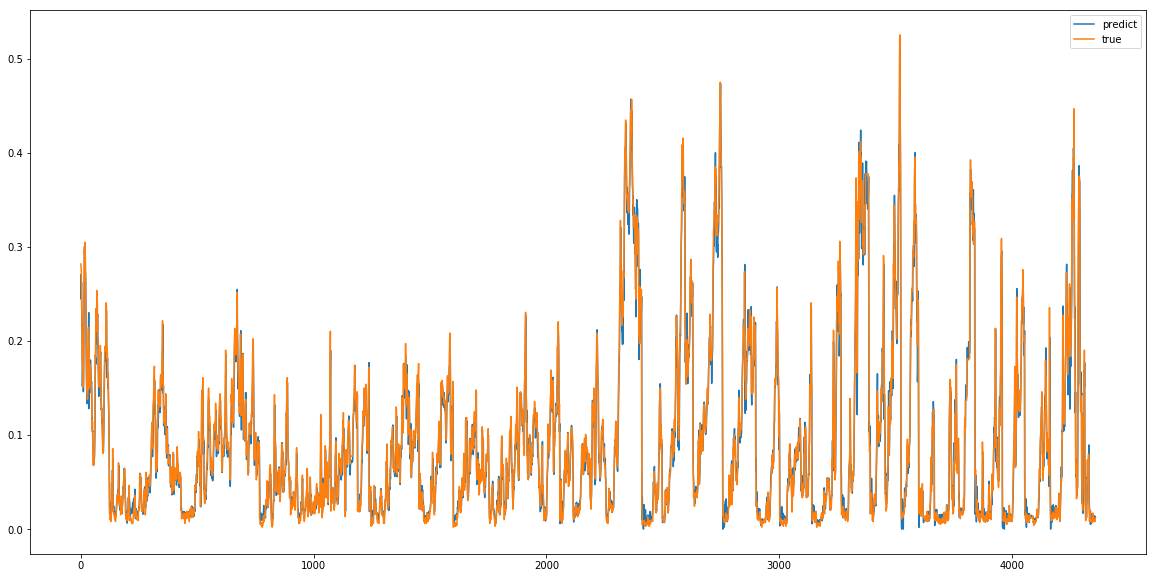

Test RMSE: 0.01796
Test MAE: 0.01116
Test MSE: 0.00032


In [525]:
## lstm(200)-cnn(5,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

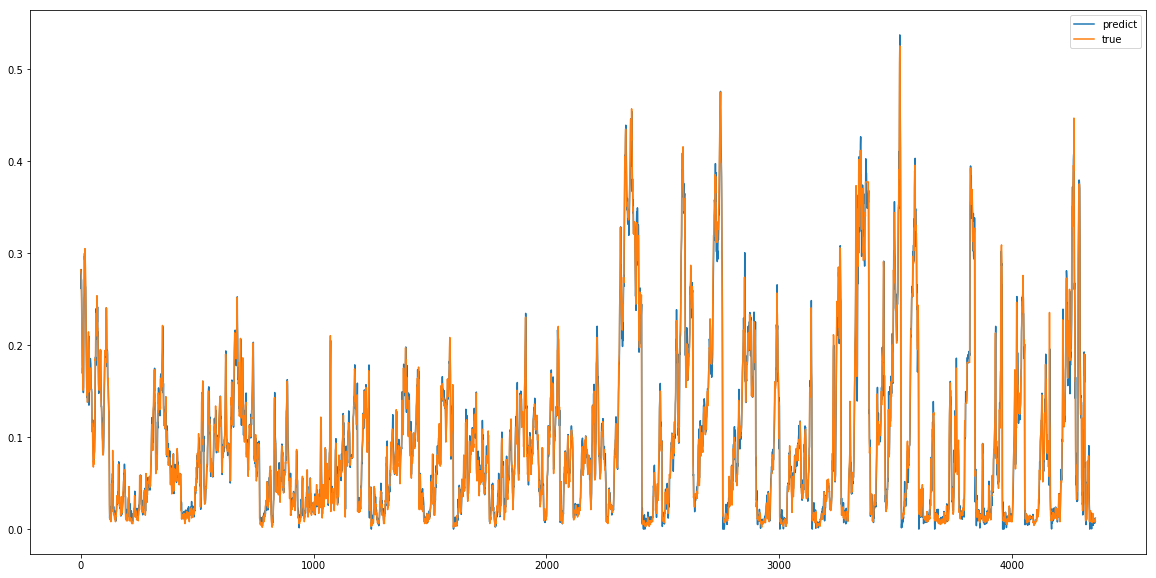

In [475]:
### lstm(100)-1dcnn(5,1), saved_weights/timedistribute_pm2.5_lstmcnn1

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [476]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01795


In [477]:
from math import *
from sklearn.metrics import *

rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

Test RMSE: 0.01795
Test MAE: 0.01083
Test MSE: 0.00032


In [ ]:
### lstm(100)-1dcnn, saved_weights/timedistribute_pm2.5_lstmcnn

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [429]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01799


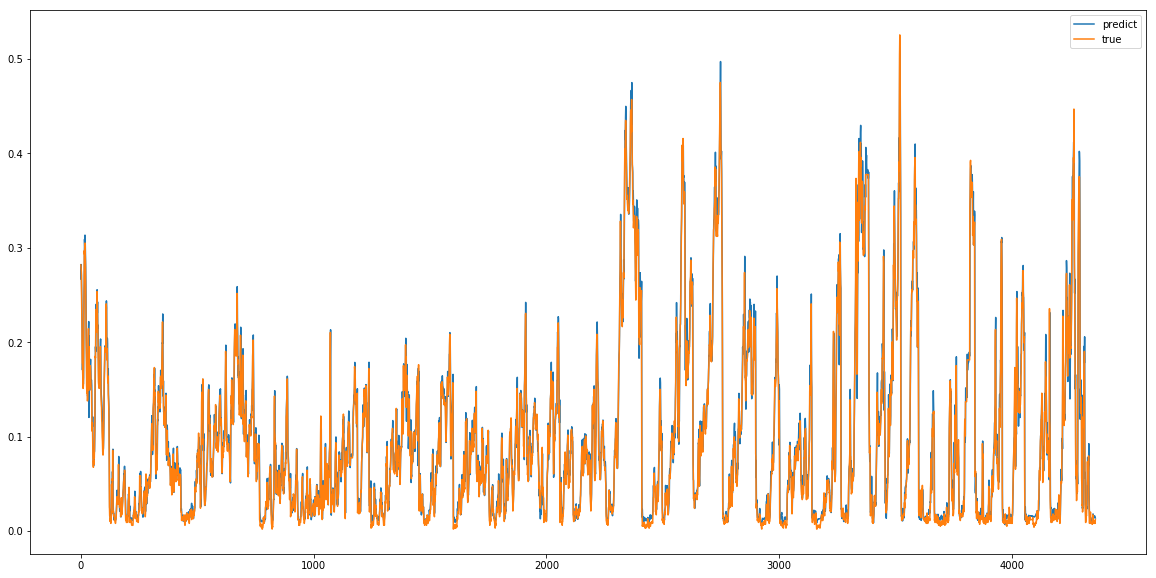

In [403]:
### bilstm(100)-1dcnn

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [400]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01774


In [404]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01812


In [ ]:
### lstm(200)-1dcnn

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [ ]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

In [420]:
### lstm(100)-1dcnn

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

ValueError: Error when checking input: expected input_74 to have shape (None, 24, 8) but got array with shape (1, 24, 11)

In [ ]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

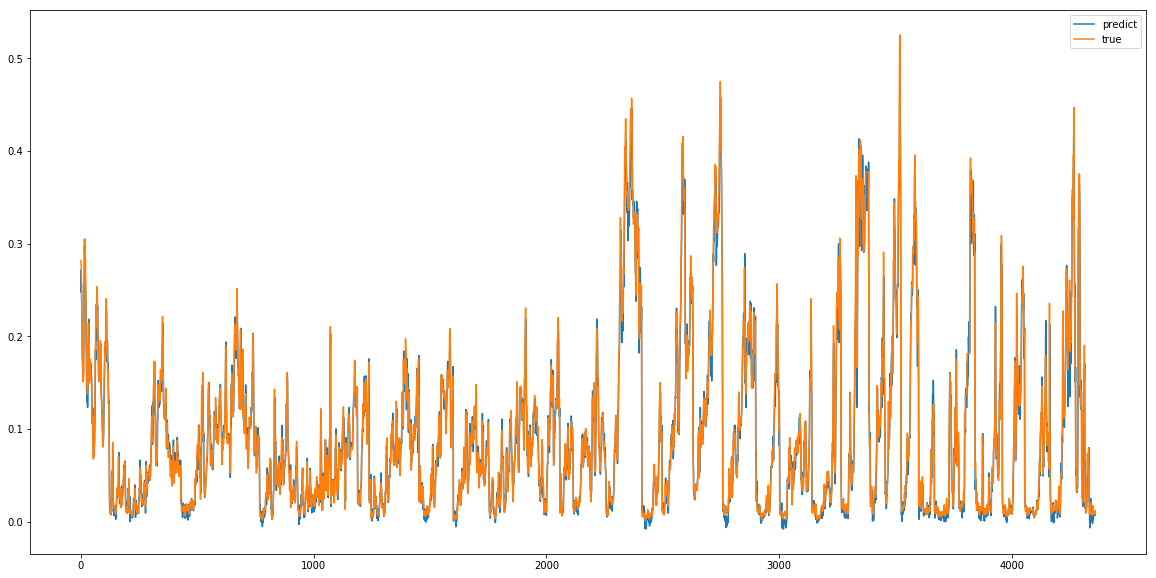

In [30]:
from matplotlib import pyplot
yhat = model.predict([testX])

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

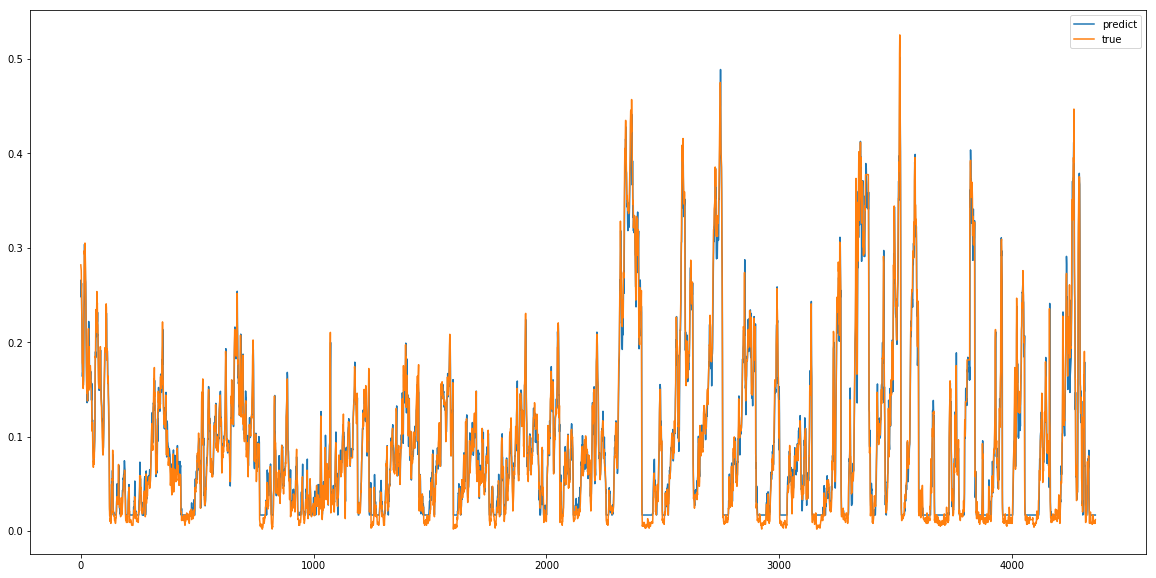

In [34]:
from matplotlib import pyplot
yhat = model.predict([testX])

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [526]:
yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)

In [527]:
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

In [564]:
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.885


### attention cnn, cnn, rescnn 순서

In [14]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01871


In [31]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01857


In [35]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01849


In [338]:
##convlstm

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01964


In [350]:
##convlstm

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01986


In [376]:

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01869


In [86]:
from tensorflow.keras.models import Model


def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

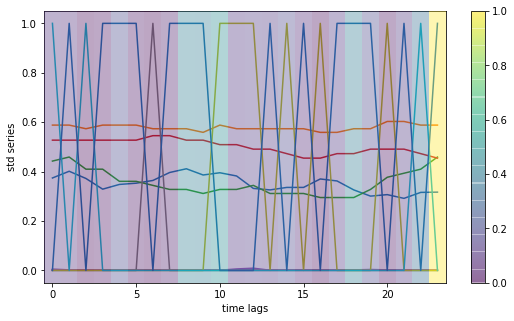

In [107]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

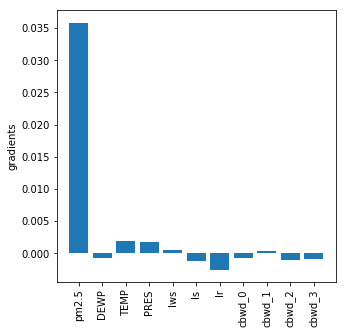

In [106]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)